# Homework #4

## Mohammad Azimpour, 810197657

### Question #1

In [1]:
from model import NSFrozenLake
from amalearn.environment import *
from amalearn.agent import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%% allowed actions
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

ACTIONS = [LEFT,DOWN,RIGHT,UP]

#%% hyperparameters
REPS = 20
EPISODES = 4000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 810197657
ACTION_PRICE = -1
PUNISH = -10
GOAL_REWARD = 50
THETA = 10

env = NSFrozenLake(studentNum=STUDENT_NUM)

In [68]:
class Q1Agent(AgentBase):
    def __init__(self, id, env, ACTIONS, DISCOUNT, ACTION_PRICE, PUNISH, GOAL_REWARD, THETA):
        super(Q1Agent, self).__init__(id, env)
        self.ACTIONS = ACTIONS
        self.DISCOUNT = DISCOUNT
        self.ACTION_PRICE = ACTION_PRICE
        self.PUNISH = PUNISH
        self.GOAL_REWARD = GOAL_REWARD
        self.THETA = THETA
        self.values = {(x, y): 0 for x in range(4) for y in range(4)}
        self.q_values = {(x, y, a): 0 for x in range(4) for y in range(4) for a in self.ACTIONS}
        self.policy = {(x, y): -1 for x in range(4) for y in range(4)}
    
    def evaluate_q_values(self, state, action):
        states, probs, fail_probs, dones = self.environment.possible_consequences(action=action ,state_now=state)
        rewards = np.array(fail_probs) * self.PUNISH - self.ACTION_PRICE + dones * self.GOAL_REWARD
        q = 0
        for i in range(len(states)):
            q += probs[i] * (rewards[i] + self.DISCOUNT * self.values[states[i]])
        self.q_values[state, action] = q
        return self.q_values[state, action]
    
    def value_iteration(self):
        while(True):
            theta = 0
            for s0 in range(4):
                for s1 in range(4):
                    v = []
                    for action in self.ACTIONS:
                        q = self.evaluate_q_values((s0, s1), action)
                        v.append(q * (1 - self.environment.map[(s0, s1)]))
                    if np.abs(max(v) - self.values[(s0, s1)]) > theta:
                        theta = np.abs(max(v) - self.values[(s0, s1)])
                    self.values[(s0, s1)] = max(v)
                    self.policy[s0, s1] = np.argmax(v)

            if self.THETA > theta:
                break
    
    def get_policy(self):
        for i in range(4):
            for j in range(4):
                print(self.policy[i, j], end = "\t")
            print()

    def get_values(self):
        for i in range(4):
            for j in range(4):
                print(self.values[i, j], end = "\t")
            print()
    

In [69]:
q1_agent = Q1Agent("1", env, ACTIONS, DISCOUNT, ACTION_PRICE, PUNISH, GOAL_REWARD, THETA)
q1_agent.value_iteration()

In [70]:
env.render()
print("\nValues:")
q1_agent.get_values()
print("\nPolicy:")
q1_agent.get_policy()


------------------------------
| 0.000 | 0.001 | 0.845 | 0.056 | 
------------------------------
| 0.193 | 0.001 | 0.323 | 0.180 | 
------------------------------
| 0.521 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.506 | 0.698 | 0.870 | 0.000 | 
------------------------------

Values:
143.54648991757648	169.52307853573032	24.716922654999998	188.39727599269787	
137.6516901359796	203.05980139320138	163.83591735448792	238.0034302947592	
95.11481836277686	239.52207499365974	286.60357181827453	340.9410419358146	
38.50214169819134	61.35819021134699	43.02212424308588	339.1585102072932	

Policy:
2	1	2	1	
2	1	1	1	
2	2	2	1	
3	3	2	1	


### Question #2

#### Part #1-2

In [114]:
class Q2P12Agent(AgentBase):
    def __init__(self, id, environment, ACTIONS, EPSILON, DISCOUNT, LEARNING_RATE):
        super(Q2P12Agent, self).__init__(id, environment)
        self.states = []
        self.actions = []
        self.rewards = []
        self.ACTIONS = ACTIONS
        self.EPSILON = EPSILON
        self.EPSILON_BASE = EPSILON
        self.DISCOUNT = DISCOUNT
        self.LEARNING_RATE = LEARNING_RATE
        self.initial_state = (0, 0)
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.policy = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        self.behavior = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        
    def decrease_epsilon(self):
        self.EPSILON /= 1.001
        
    def update_q_values(self, state, action, G):
        q = self.q_values[state, action]
        self.q_values[state, action] = q + self.LEARNING_RATE * (G - q)
        
    def update_behavior(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.q_values[state, action])
        self.behavior[state] = np.argmax(q)
    
    def select_action(self, state):
        if np.random.rand() > self.EPSILON:
            return self.behavior[state]
        else:
            return np.random.choice(self.ACTIONS)
    
    def update_policy(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.q_values[state, action])
        self.policy[state] = np.argmax(q)
    
    def generate_episode(self, initial_state):
        state = initial_state
        done = False
        while(not done):
            self.states.append(state)
            action = self.select_action(state)
            self.actions.append(action)
            state,reward,done,_ = self.environment.step(action)
            self.rewards.append(reward)
        return self.states, self.actions, self.rewards
    
    def run(self, reps, episodes, WINDOW_SIZE, DECREASE_EPSILON, MAX_REWARDS):
        repeats_rewards_average = []
        regret = []
        rewards_sw = []
        for rep in range(reps):
            regret = []
            print(rep)
            rewards_average = []
            rewards_sums = []
            self.reset(DECREASE_EPSILON)
            for episode in range(episodes):
                self.actions = []
                self.rewards = []
                self.states = []
                self.envionment.reset()      
                G = 0.0
                states, actions, rewards = self.generate_episode(self.initial_state)
                s = np.sum(rewards)
                rewards_sums.append(s)
                if(episode == 0):
                    regret.append(MAX_REWARDS - s)
                else:
                    regret.append(regret[episode-1] + MAX_REWARDS - s)
                for i in reversed(range(len(states))):
                    G = self.DISCOUNT * G + rewards[i]
                    self.update_q_values(states[i], actions[i], G)
                    self.update_policy(states[i])
                    self.update_behavior(states[i])
                    if actions[i] != self.policy[states[i]]:
                        break
                if(DECREASE_EPSILON):
                    self.decrease_epsilon()
            repeats_rewards_average.append(np.mean(rewards_sums))
            for i in range(len(rewards_sums)):
                rewards_average.append(np.mean(rewards_sums[max(0,i-WINDOW_SIZE):i]))
            rewards_sw.append(rewards_average)
        return rewards_sw, repeats_rewards_average, regret
    
    def reset(self, DECREASE_EPSILON):
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.policy = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        self.behavior = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        if(DECREASE_EPSILON):
            self.EPSILON = self.EPSILON_BASE

In [115]:
agent_q2p12_ce = Q2P12Agent("2", env, ACTIONS, 0.1, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p12_ce, repeats_rewards_average_q2p12_ce, regret_q2p12_ce = agent_q2p12_ce.run(REPS, EPISODES, 100, False, 35)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


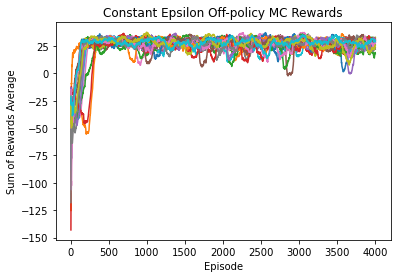

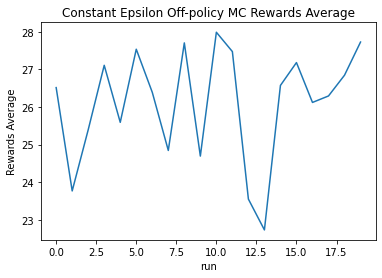

In [131]:
for i in range(len(rewards_sw_q2p12_ce)):
    plt.plot(rewards_sw_q2p12_ce[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Constant Epsilon Off-policy MC Rewards")
plt.savefig("figs/2-1-2-ce-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p12_ce)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Constant Epsilon Off-policy MC Rewards Average")
plt.savefig("figs/2-1-2-ce-ra.png")
plt.show()

In [117]:
agent_q2p12_de = Q2P12Agent("3", env, ACTIONS, 0.99, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p12_de, repeats_rewards_average_q2p12_de, regret_q2p12_de = agent_q2p12_de.run(REPS, EPISODES, 100, True, 35)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


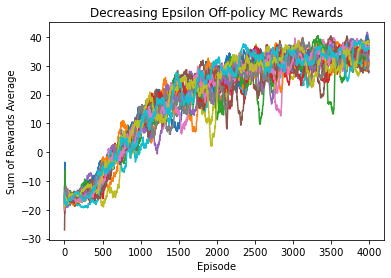

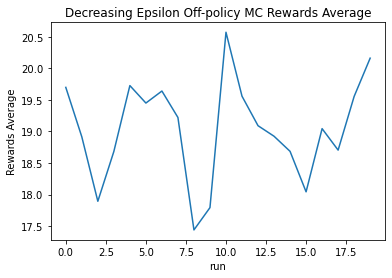

In [132]:
for i in range(len(rewards_sw_q2p12_de)):
    plt.plot(rewards_sw_q2p12_de[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Decreasing Epsilon Off-policy MC Rewards")
plt.savefig("figs/2-1-2-de-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p12_de)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Decreasing Epsilon Off-policy MC Rewards Average")
plt.savefig("figs/2-1-2-de-ra.png")
plt.show()

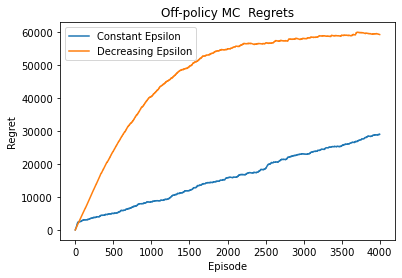

In [133]:
plt.plot(regret_q2p12_ce)
plt.plot(regret_q2p12_de)
plt.xlabel("Episode")
plt.ylabel("Regret")
plt.title("Off-policy MC  Regrets")
plt.legend(["Constant Epsilon", "Decreasing Epsilon"])
plt.savefig("figs/2-1-2-r.png")
plt.show()

#### Part #2

In [122]:
class Q2P2Agent(AgentBase):
    def __init__(self, id, environment, ACTIONS, EPSILON, DISCOUNT, LEARNING_RATE):
        super(Q2P2Agent, self).__init__(id, environment)
        self.states = []
        self.actions = []
        self.rewards = []
        self.ACTIONS = ACTIONS
        self.EPSILON = EPSILON
        self.EPSILON_BASE = EPSILON
        self.DISCOUNT = DISCOUNT
        self.LEARNING_RATE = LEARNING_RATE
        self.initial_state = (0, 0)
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.behavior = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        
    def decrease_epsilon(self):
        self.EPSILON /= 1.001
        
    def get_max_q_value(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.q_values[state, action])
        return np.max(q)
    
    def update_q_values(self, state, action, next_state, reward):
        q = self.q_values[state, action]
        mq = self.get_max_q_value(next_state)
        self.q_values[state, action] = q + self.LEARNING_RATE * (reward + self.DISCOUNT * mq - q)
        
    def select_action(self, state):
        if np.random.rand() > self.EPSILON:
            return self.behavior[state]
        else:
            return np.random.choice(self.ACTIONS)
    
    def update_behavior(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.q_values[state, action])
        self.behavior[state] = np.argmax(q)
    
    def run(self, reps, episodes, WINDOW_SIZE, DECREASE_EPSILON, MAX_REWARDS):
        repeats_rewards_average = []
        regret = []
        rewards_sw = []
        for rep in range(reps):
            self.reset(DECREASE_EPSILON)
            regret = []
            print(rep)
            rewards_average = []
            rewards_sum = []
            for episode in range(episodes):
                self.envionment.reset()      
                state = self.initial_state
                done = False
                s = 0
                while(not done):
                    action = self.select_action(state)
                    next_state,reward,done,_ = self.environment.step(action)
                    s += reward
                    self.update_q_values(state, action, next_state, reward)
                    self.update_behavior(state)
                    state = next_state
                rewards_sum.append(s)
                if(len(regret) == 0):
                    regret.append(MAX_REWARDS - reward)
                else:
                    regret.append(regret[-1] + MAX_REWARDS - reward)
                if(DECREASE_EPSILON):
                    self.decrease_epsilon()

            repeats_rewards_average.append(np.mean(rewards_sum))
            for i in range(len(rewards_sum)):
                rewards_average.append(np.mean(rewards_sum[max(0,i-WINDOW_SIZE):i]))
            rewards_sw.append(rewards_average)
        return rewards_sw, repeats_rewards_average, regret

    def reset(self, DECREASE_EPSILON):
        self.actions = []
        self.rewards = []
        self.states = []
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.policy = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        self.behavior = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        if(DECREASE_EPSILON):
            self.EPSILON = self.EPSILON_BASE

In [7]:
EPSIODES = 2000

In [141]:
agent_q2p2_ce = Q2P2Agent("4", env, ACTIONS, 0.1, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p2_ce, repeats_rewards_average_q2p2_ce, regret_q2p2_ce = agent_q2p2_ce.run(REPS, 2000, 100, False, 45)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


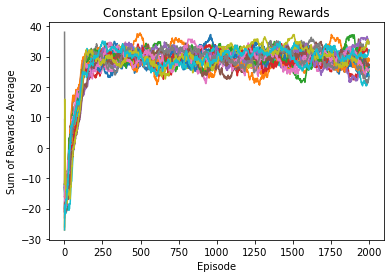

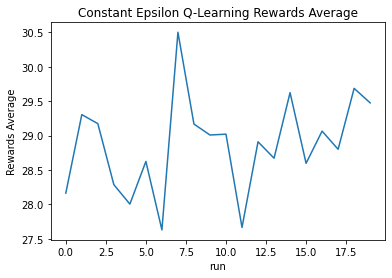

In [142]:
for i in range(len(rewards_sw_q2p2_ce)):
    plt.plot(rewards_sw_q2p2_ce[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Constant Epsilon Q-Learning Rewards")
plt.savefig("figs/2-2-ce-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p2_ce)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Constant Epsilon Q-Learning Rewards Average")
plt.savefig("figs/2-2-ce-ra.png")
plt.show()

In [143]:
agent_q2p2_de = Q2P2Agent("5", env, ACTIONS, 0.99, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p2_de, repeats_rewards_average_q2p2_de, regret_q2p2_de = agent_q2p2_de.run(REPS, 2000, 100, True, 45)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


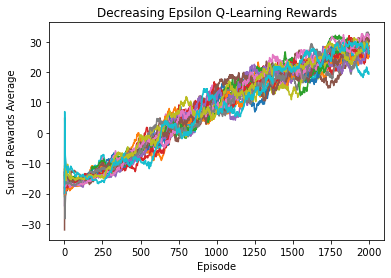

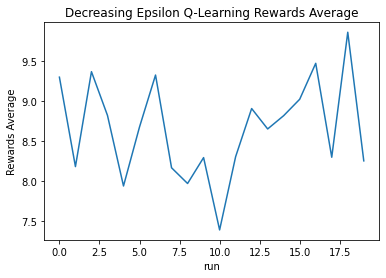

In [144]:
for i in range(len(rewards_sw_q2p2_de)):
    plt.plot(rewards_sw_q2p2_de[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Decreasing Epsilon Q-Learning Rewards")
plt.savefig("figs/2-2-de-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p2_de)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Decreasing Epsilon Q-Learning Rewards Average")
plt.savefig("figs/2-2-de-ra.png")
plt.show()

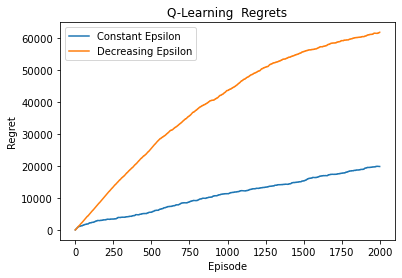

In [145]:
plt.plot(regret_q2p2_ce)
plt.plot(regret_q2p2_de)
plt.xlabel("Episode")
plt.ylabel("Regret")
plt.title("Q-Learning  Regrets")
plt.legend(["Constant Epsilon", "Decreasing Epsilon"])
plt.savefig("figs/2-2-r.png")
plt.show()

#### Part #3

In [152]:
class Q2P3SARSAAgent(AgentBase):
    def __init__(self, id, env, EPSILON, ACTIONS, DISCOUNT, LEARNING_RATE):
        super(Q2P3SARSAAgent, self).__init__(id, env)
        self.EPSILON = EPSILON
        self.EPSILON_BASE = EPSILON
        self.ACTIONS = ACTIONS
        self.DISCOUNT = DISCOUNT
        self.LEARNING_RATE = LEARNING_RATE
        self.initial_state = (0, 0)
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.policy = {(x, y): np.random.choice(self.ACTIONS) for x in range(4) for y in range(4)}
    
    def decrease_epsilon(self):
        self.EPSILON /= 1.001
    
    def update_q_values(self, state, action, next_state, next_action, reward):
        q = self.q_values[state, action]
        _q = self.q_values[next_state, next_action]
        self.q_values[state, action] = q + self.LEARNING_RATE * (reward + self.DISCOUNT * _q - q)
    
    def update_policy(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.q_values[state, action])
        self.policy[state] = np.argmax(q)
    
    def select_action(self, state):
        if np.random.rand() > self.EPSILON:
            return self.policy[state]
        else:
            return np.random.choice(self.ACTIONS)
    
    def run(self, reps, episodes, WINDOW_SIZE, DECREASE_EPSILON, MAX_REWARDS):
        repeats_rewards_average = []
        regret = []
        rewards_sw = []
        for rep in range(reps):
            self.reset(DECREASE_EPSILON)
            rewards_average = []
            rewards_sum = []
            self.envionment.reset()
            regret = []
            print(rep)
            for episode in range(episodes):
                self.envionment.reset()      
                state = self.initial_state
                action = self.select_action(state)
                done = False
                s = 0
                while(not done):
                    next_state,reward,done,_ = self.environment.step(action)
                    s += reward
                    next_action = self.select_action(next_state)
                    self.update_q_values(state, action, next_state, next_action, reward)
                    self.update_policy(state)
                    state = next_state
                    action = next_action
                rewards_sum.append(s)
                if(len(regret) == 0):
                    regret.append(MAX_REWARDS - reward)
                else:
                    regret.append(regret[-1] + MAX_REWARDS - reward)
                if(DECREASE_EPSILON):
                    self.decrease_epsilon()

            repeats_rewards_average.append(np.mean(rewards_sum))
            for i in range(len(rewards_sum)):
                rewards_average.append(np.mean(rewards_sum[max(0,i-WINDOW_SIZE):i]))
            rewards_sw.append(rewards_average)
        return rewards_sw, repeats_rewards_average, regret
    
    def reset(self, DECREASE_EPSILON):
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.policy = {(x, y): np.random.choice(self.ACTIONS) for x in range(4) for y in range(4)}
        if(DECREASE_EPSILON):
            self.EPSILON = self.EPSILON_BASE

In [153]:
agent_q2p3S_ce = Q2P3SARSAAgent("6", env, 0.1, ACTIONS, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p3S_ce, repeats_rewards_average_q2p3S_ce, regret_q2p3S_ce = agent_q2p3S_ce.run(REPS, 2000, 100, False, 45)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


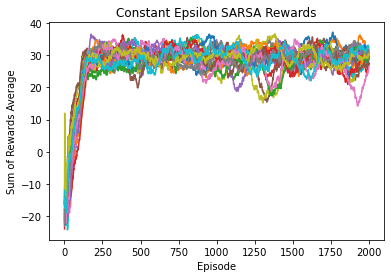

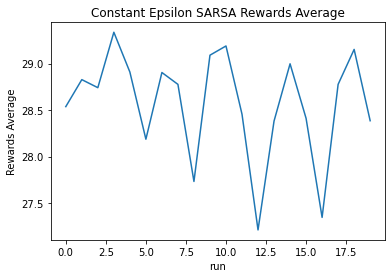

In [154]:
for i in range(len(rewards_sw_q2p3S_ce)):
    plt.plot(rewards_sw_q2p3S_ce[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Constant Epsilon SARSA Rewards")
plt.savefig("figs/2-3S-ce-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p3S_ce)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Constant Epsilon SARSA Rewards Average")
plt.savefig("figs/2-3S-ce-ra.png")
plt.show()

In [155]:
agent_q2p3S_de = Q2P3SARSAAgent("7", env, 0.99, ACTIONS, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p3S_de, repeats_rewards_average_q2p3S_de, regret_q2p3S_de = agent_q2p3S_de.run(REPS, 2000, 100, True, 45)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


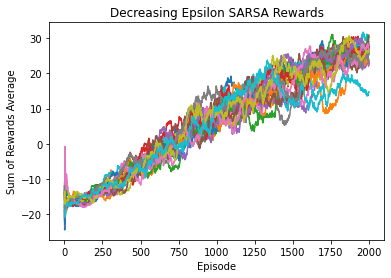

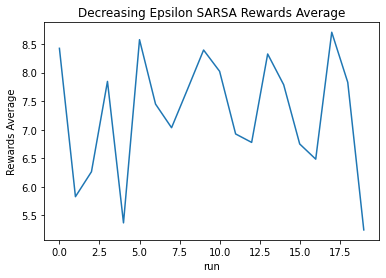

In [158]:
for i in range(len(rewards_sw_q2p3S_de)):
    plt.plot(rewards_sw_q2p3S_de[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Decreasing Epsilon SARSA Rewards")
plt.savefig("figs/2-3S-de-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p3S_de)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Decreasing Epsilon SARSA Rewards Average")
plt.savefig("figs/2-3S-de-ra.png")
plt.show()

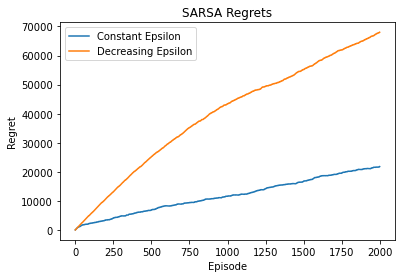

In [157]:
plt.plot(regret_q2p3S_ce)
plt.plot(regret_q2p3S_de)
plt.xlabel("Episode")
plt.ylabel("Regret")
plt.title("SARSA Regrets")
plt.legend(["Constant Epsilon", "Decreasing Epsilon"])
plt.savefig("figs/2-3S-r.png")
plt.show()

In [159]:
class Q2P32STBAgent(AgentBase):
    def __init__(self, id, env, EPSILON, ACTIONS, DISCOUNT, LEARNING_RATE):
        super(Q2P32STBAgent, self).__init__(id, env)
        self.EPSILON = EPSILON
        self.EPSILON_BASE = EPSILON
        self.ACTIONS = ACTIONS
        self.DISCOUNT = DISCOUNT
        self.LEARNING_RATE = LEARNING_RATE
        self.initial_state = (0, 0)
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in ACTIONS}
        self.policy = {(i, j): np.random.choice(ACTIONS) for i in range(4) for j in range(4)}
        self.behavior = {(i, j): np.random.choice(ACTIONS) for i in range(4) for j in range(4)}
    
    def decrease_epsilon(self):
        self.EPSILON /= 1.001
    
    def update_q_value(self, state, action, G):
        q = self.q_values[state, action]
        self.q_values[state, action] = q + self.LEARNING_RATE * (G - q)
    
    def update_behavior(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.q_values[state, action])
        self.behavior[state] = np.argmax(q)
    
    def update_policy(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.q_values[state, action])
        self.policy[state] = np.argmax(q)
            
    def select_action(self, state):
        if np.random.rand() > self.EPSILON:
            return self.behavior[state]
        else:
            return np.random.choice(self.ACTIONS)
    
    def run(self, reps, episodes, WINDOW_SHAPE, DECREASE_EPSILON, MAX_REWARDS):
        repeats_rewards_average = []
        n = 2
        regret = []
        rewards_sw = []
        for rep in range(reps):
            self.reset(DECREASE_EPSILON)
            rewards_average = []
            rewadrs_sum = []
            self.envionment.reset()
            regret = []
            print(rep)
            for episode in range(episodes):
                s = 0
                T = 1000000000
                tau = 0
                t = 0
                env.reset()
                state = self.initial_state
                next_state = None
                prev_state = None
                action = agent.select_action(state)
                next_action = -1
                prev_action = -1
                reward = 0
                next_reward = 0
                while(tau < T - 1):
                    s += reward
                    if t < T:
                        next_state,next_reward,done,_ = self.environment.step(action)
                        if done:
                            T = t + 1
                        else:
                            next_action = self.select_action(next_state)
                    tau = t + 1 - n
                    if tau >= 0:
                        G = next_reward
                        if t + 1 < T:
                            G += self.DISCOUNT * self.q_values[next_state, next_action]
                        if min(t, T - 1) >= tau + 1:
                            a = agent.policy[state]
                            if a == action:
                                G = reward + self.DISCOUNT * G
                            else:
                                G = reward + self.DISCOUNT * self.q_values[state, a]
                        self.update_q_value(prev_state, prev_action, G)
                        self.update_behavior(prev_state)
                        self.update_policy(prev_state)
                    t += 1
                    prev_state = state
                    state = next_state
                    prev_action = action
                    action = next_action
                    reward = next_reward
                rewadrs_sum.append(s)
                if(len(regret) == 0):
                    regret.append(MAX_REWARDS - s)
                else:
                    regret.append(regret[-1] + MAX_REWARDS - s)
                if(DECREASE_EPSILON):
                    self.decrease_epsilon()
            repeats_rewards_average.append(np.mean(rewadrs_sum))
            for i in range(len(rewadrs_sum)):
                rewards_average.append(np.mean(rewadrs_sum[max(0,i-WINDOW_SHAPE):i]))
            rewards_sw.append(rewards_average)
        return rewards_sw, repeats_rewards_average, regret
    
    def reset(self, DECREASE_EPSILON):
        self.q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in ACTIONS}
        self.policy = {(i, j): np.random.choice(ACTIONS) for i in range(4) for j in range(4)}
        self.behavior = {(i, j): np.random.choice(ACTIONS) for i in range(4) for j in range(4)}
        if(DECREASE_EPSILON):
            self.EPSILON = self.EPSILON_BASE

In [160]:
agent_q2p32_ce = Q2P32STBAgent("8", env, 0.1, ACTIONS, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p32_ce, repeats_rewards_average_q2p32_ce, regret_q2p32_ce = agent_q2p32_ce.run(REPS, 2000, 100, False, 45)

0


D:\progs\Anaconda\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\progs\Anaconda\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


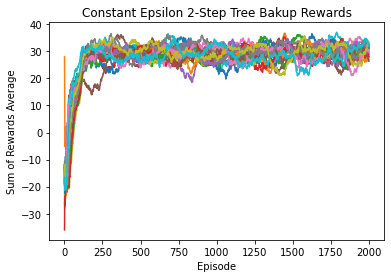

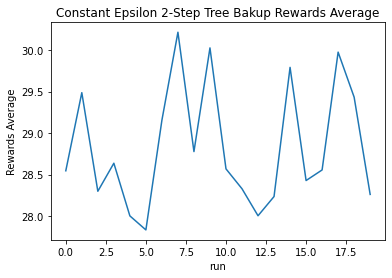

In [161]:
for i in range(len(rewards_sw_q2p32_ce)):
    plt.plot(rewards_sw_q2p32_ce[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Constant Epsilon 2-Step Tree Bakup Rewards")
plt.savefig("figs/2-32-ce-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p32_ce)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Constant Epsilon 2-Step Tree Bakup Rewards Average")
plt.savefig("figs/2-32-ce-ra.png")
plt.show()

In [162]:
agent_q2p32_de = Q2P32STBAgent("9", env, 0.99, ACTIONS, DISCOUNT, LEARNING_RATE)
rewards_sw_q2p32_de, repeats_rewards_average_q2p32_de, regret_q2p32_de = agent_q2p32_de.run(REPS, 2000, 100, True, 45)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


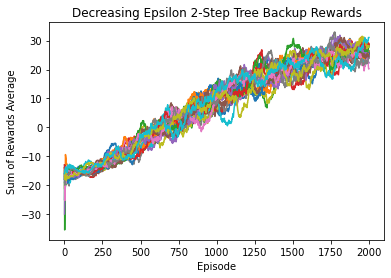

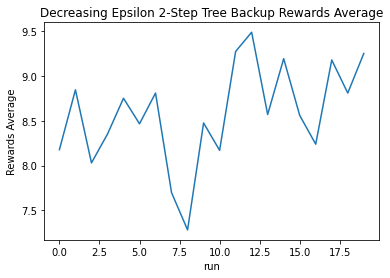

In [163]:
for i in range(len(rewards_sw_q2p32_de)):
    plt.plot(rewards_sw_q2p32_de[i])
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards Average")
    plt.title("Decreasing Epsilon 2-Step Tree Backup Rewards")
plt.savefig("figs/2-32-de-sl.png")
plt.show()
plt.plot(repeats_rewards_average_q2p32_de)
plt.xlabel("run")
plt.ylabel("Rewards Average")
plt.title("Decreasing Epsilon 2-Step Tree Backup Rewards Average")
plt.savefig("figs/2-32-de-ra.png")
plt.show()

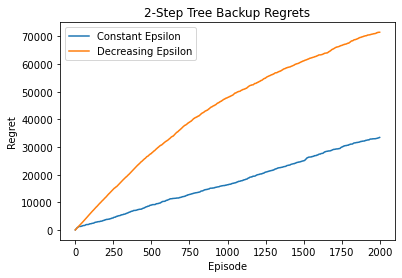

In [164]:
plt.plot(regret_q2p32_ce)
plt.plot(regret_q2p32_de)
plt.xlabel("Episode")
plt.ylabel("Regret")
plt.title("2-Step Tree Backup Regrets")
plt.legend(["Constant Epsilon", "Decreasing Epsilon"])
plt.savefig("figs/2-32-r.png")
plt.show()

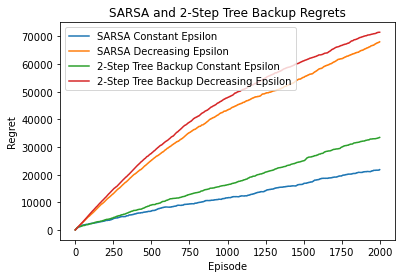

In [165]:
plt.plot(regret_q2p3S_ce)
plt.plot(regret_q2p3S_de)
plt.plot(regret_q2p32_ce)
plt.plot(regret_q2p32_de)
plt.xlabel("Episode")
plt.ylabel("Regret")
plt.title("SARSA and 2-Step Tree Backup Regrets")
plt.legend(["SARSA Constant Epsilon", "SARSA Decreasing Epsilon", "2-Step Tree Backup Constant Epsilon", "2-Step Tree Backup Decreasing Epsilon"])
plt.savefig("figs/2-3-r.png")
plt.show()

### Question #3

In [9]:
class Q3Agent(AgentBase):
    def __init__(self, id, environment, EPSILON, ACTIONS, ACTION_PRICE, GOAL_REWARD, PUNISH, DISCOUNT, THETA):
        super(Q3Agent, self).__init__(id, environment)
        self.EPSILON = EPSILON
        self.ACTIONS = ACTIONS
        self.ACTION_PRICE = ACTION_PRICE
        self.GOAL_REWARD = GOAL_REWARD
        self.PUNISH = PUNISH
        self.DISCOUNT = DISCOUNT
        self.THETA = THETA
        self.initial_state = (0, 0)
        self.model_based_q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in ACTIONS}
        self.model_free_q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.total_q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.state_values = {(x, y): 0 for x in range(4) for y in range(4)}
        self.behavior = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
                        
    def get_max_model_free_q_value(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.model_free_q_values[state, action])
        return np.max(q)
            
    def update_total_q_values(self, state, action, w):
        self.total_q_values[state, action] = w * self.model_based_q_values[state, action] + (1 - w) * self.model_free_q_values[state, action]
        
    def update_behavior(self, state):
        q = []
        for action in self.ACTIONS:
            q.append(self.total_q_values[state, action])
        self.behavior[state] = np.argmax(q)
            
    def select_action(self, state):
        if np.random.rand() > self.EPSILON:
            return self.behavior[state]
        else:
            return np.random.choice(self.ACTIONS)

    def evaluate_model_based_q_values(self, state, action):
        states, probs, fail_probs, dones = self.environment.possible_consequences(action=action ,state_now=state)
        rewards = np.array(fail_probs) * self.PUNISH - self.ACTION_PRICE + dones * self.GOAL_REWARD
        q = 0
        for i in range(len(states)):
            q += probs[i] * (rewards[i] + self.DISCOUNT * self.state_values[states[i]])
        self.model_based_q_values[state, action] = q
        return q
    
    def update_model_free_q_values(self, state, action, next_state, reward):
        q = self.model_free_q_values[state, action]
        _q = self.get_max_model_free_q_value(next_state)
        self.model_free_q_values[state, action] = q + LEARNING_RATE * (reward + DISCOUNT * _q - q)

    def value_iteration(self):
        while(True):
            theta = 0
            for s0 in range(4):
                for s1 in range(4):
                    if (s0, s1) == (3, 3):
                        continue
                    v = []
                    for action in self.ACTIONS:
                        q = self.evaluate_model_based_q_values((s0, s1), action)
                        v.append(q * (1 - self.environment.map[(s0, s1)]))
                    if np.abs(max(v) - self.state_values[(s0, s1)]) > theta:
                        theta = np.abs(max(v) - self.state_values[(s0, s1)])
                    self.state_values[(s0, s1)] = max(v)
                    self.behavior[s0, s1] = np.argmax(v)

            if self.THETA > theta:
                break

    def run(self, reps, episodes, w):
        self.environment.reset()
        self.value_iteration()
        rewards_sum = []
        for rep in range(reps):
            self.reset()
            s = 0
            for episode in range(episodes):
                self.environment.reset()
                state = self.initial_state
                done = False
                while(not done):
                    action = self.select_action(state)
                    next_state,reward,done,_ = self.environment.step(action)
                    s += reward
                    self.update_model_free_q_values(state, action, next_state, reward)
                    self.update_total_q_values(state, action, w)
                    self.update_behavior(state)
                    state = next_state
            rewards_sum.append(s)
        return np.mean(rewards_sum)
    
    def reset(self):
        self.model_based_q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in ACTIONS}
        self.model_free_q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.total_q_values = {((i, j), a): 0 for i in range(4) for j in range(4) for a in self.ACTIONS}
        self.state_values = {(x, y): 0 for x in range(4) for y in range(4)}
        self.behavior = {(i, j): np.random.choice(self.ACTIONS) for i in range(4) for j in range(4)}
        

In [11]:
env = NSFrozenLake(studentNum=STUDENT_NUM, nonStationary=True)
agent_3 = Q3Agent("10", env, 0.1, ACTIONS, ACTION_PRICE, GOAL_REWARD, PUNISH, DISCOUNT, THETA)
ws = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rewards = []
for i in range(10):
    rewards.append(agent_3.run(REPS, EPSIODES, ws[i]))
    print(rewards[-1])

53565.8
59519.8
57564.4
56494.35
56898.2
56221.15
56279.95
56577.3
56355.6
-83166.45


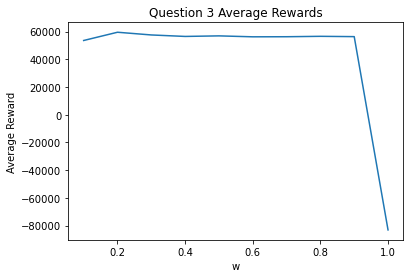

In [12]:
plt.plot(ws, rewards)
plt.xlabel("w")
plt.ylabel("Average Reward")
plt.title("Question 3 Average Rewards")
plt.savefig("figs/3.png")
plt.show()

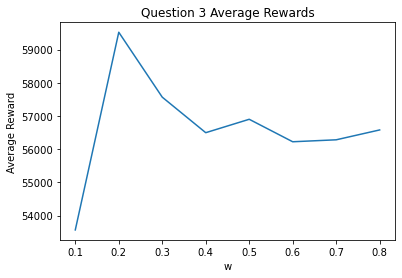

In [14]:
plt.plot(ws[0:8], rewards[0:8])
plt.xlabel("w")
plt.ylabel("Average Reward")
plt.title("Question 3 Average Rewards")
plt.savefig("figs/3-2.png")
plt.show()